### Simple Audio Recognition

In this notebook we are going to walk through how we can do audio recoginition practically by example. We are going to follow the one of the tensorflow audio tutorial which can be found [here](https://www.tensorflow.org/tutorials/audio/simple_audio).

In this notebook we are going to create and train a basic Automaic Speech Recognition (ASR) which will be able to classify `8` different commands. We are going to use the [Speech Commands dataset (Warden, 2018)](https://www.tensorflow.org/datasets/catalog/speech_commands) dataset from tensorflow datasets.


### Installation of Packages
In the following code cell we are going to install the packages that we are going to use in this notebook.


In this notebook we are going to use the `convulutional neural network` to do audio classification based on spectograms. So we will convert the audio tensors to `spectograms` images and use `CNN` to do the classification of audios.


In [ ]:
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

### Imports

In the following code cell we are going to import all the different packages that we are going to use in this notebook. 

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from IPython import display
import helperfns

keras.__version__, tf.__version__

('2.10.0', '2.10.0')

### Seed
In the following code cell we are going to set the seed for experiment reproducivity.

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Dataset

In this notebook we are going to use the `mini` dataset to save time. The original dataset consists of over `105,000` audio files in the WAV (Waveform) audio file format of people saying `35` different words. This data was collected by Google and released under a CC BY license.

We will download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data'
)


The dataset audios are stored in folders. And there are `8` folders and each folder consist of audios of that command. In the followcing code cell we are going to extract all the commands that we have in this dataset.
  

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands

array(['up', 'go', 'left', 'yes', 'no', 'stop', 'right', 'down'],
      dtype='<U9')

Beacuse our commands are divided into directories we can easily load the data using the [`keras.utils.audio_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory) function.

Our audios are clips that are at most `1` second long and has less thans `16kHz`. The `output_sequence_length=16000` argument pads the short ones to 1 second and trim the long ones to `1s` so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed = SEED,
    output_sequence_length=16000,
    subset='both',
    label_mode="int" # sparse_categorical_crossentropy  loss function
)

label_names = np.array(train_ds.class_names)
label_names

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  return tf.squeeze(audio, axis=-1), labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over `any` shard will load `all` the data, and only keep it's fraction. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [11]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

Let's plot waveforms.

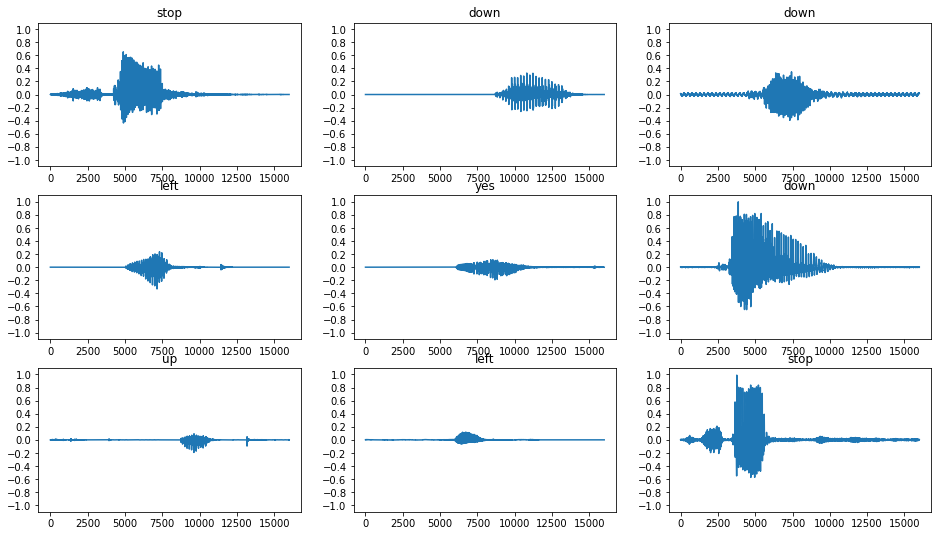

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

### Converting waveforms to spectograms

The waveforms in the dataset are represented in the time domain. Next, we'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. we will feed the spectrogram images into our neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when we convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this notebook we'll only use the magnitude, which we can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  display.display(display.Audio(waveform, rate=16000))
  print()

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)



Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)



Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


Now, define a function for plotting a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

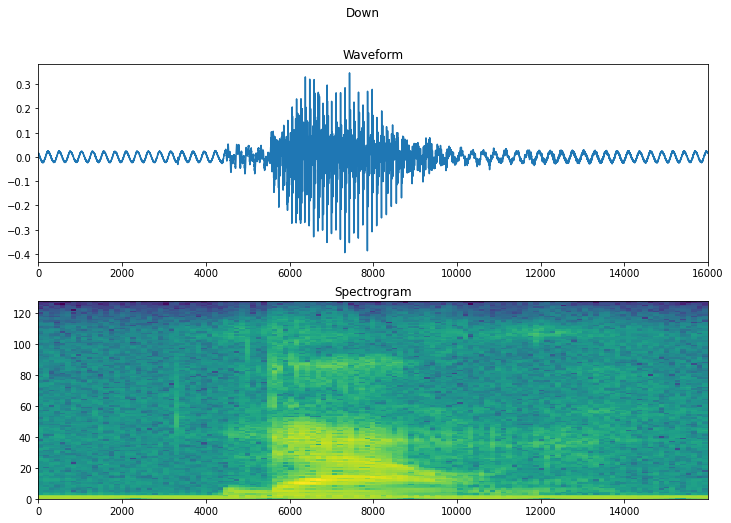

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now we can create spectogram dataset from the audio dataset for all our `3` different sets.

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

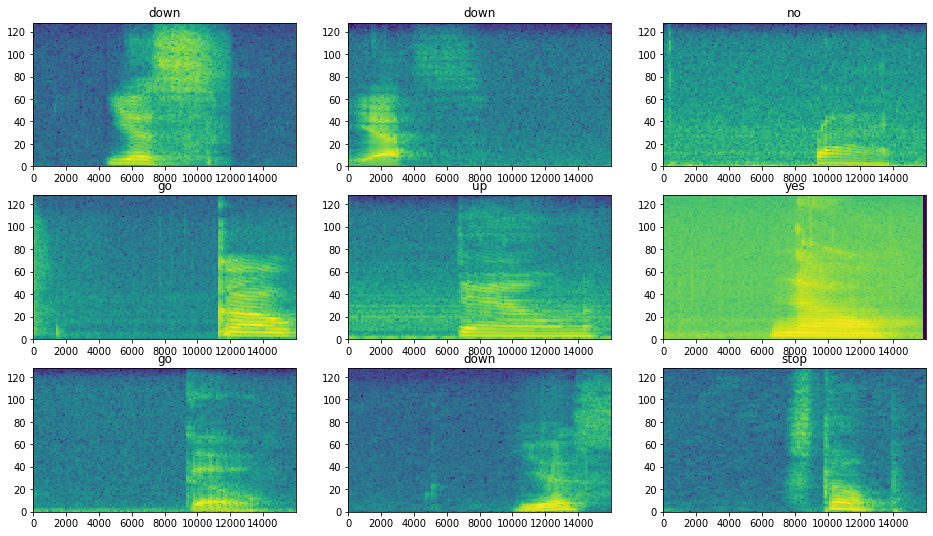

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

### Building and Training Our Model

Our model will be trained based on the spectogram dataset. We are going to  apply `cache` and `prefetch` operations on our dataset to reduce latency while training the model.

Our model in this notebook will be using `Convolutional Nwural Network (CNN)` since we transformed our audios into spectograms images.

Our `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).


In [21]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(commands)
input_shape, num_labels

(TensorShape([124, 129, 1]), 8)

In [22]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


In [23]:
model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels, activation='sigmoid'),
], name='asr')

model.summary()

Model: "asr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0       

### Combiling the model.

Note that we are going to use the `Adam` optimizer with default parameters and `SparseCategoricalCrossentropy` loss function an we are going to set `from_logits=False` since the last layer of our model has a `sigmoid` activation function. The reason we are using `SparseCategoricalCrossentropy` loss function is because our labels are integer values and they are not `one-hot-encoded`.

In [24]:
model.compile(
    optimizer= keras.optimizers.Adam(),
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Training the model for `10` epochs.

In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks= keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 31s 249ms/step - loss: 1.7806 - accuracy: 0.3586 - val_loss: 1.3825 - val_accuracy: 0.5169
Epoch 2/10
100/100 [==============================] - 18s 173ms/step - loss: 1.1979 - accuracy: 0.5795 - val_loss: 1.0172 - val_accuracy: 0.6458
Epoch 3/10
100/100 [==============================] - 9s 89ms/step - loss: 0.8902 - accuracy: 0.6933 - val_loss: 0.7825 - val_accuracy: 0.7331
Epoch 4/10
100/100 [==============================] - 9s 90ms/step - loss: 0.7207 - accuracy: 0.7412 - val_loss: 0.6551 - val_accuracy: 0.7799
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6243 - accuracy: 0.7820 - val_loss: 0.5833 - val_accuracy: 0.8073
Epoch 6/10
100/100 [==============================] - 11s 105ms/step - loss: 0.5417 - accuracy: 0.8041 - val_loss: 0.5694 - val_accuracy: 0.8112
Epoch 7/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4733 - accuracy: 0.8341 - val_loss: 0.5195 - val_accura

Let's plot the training and validation loss curves to check how your model has improved during training:

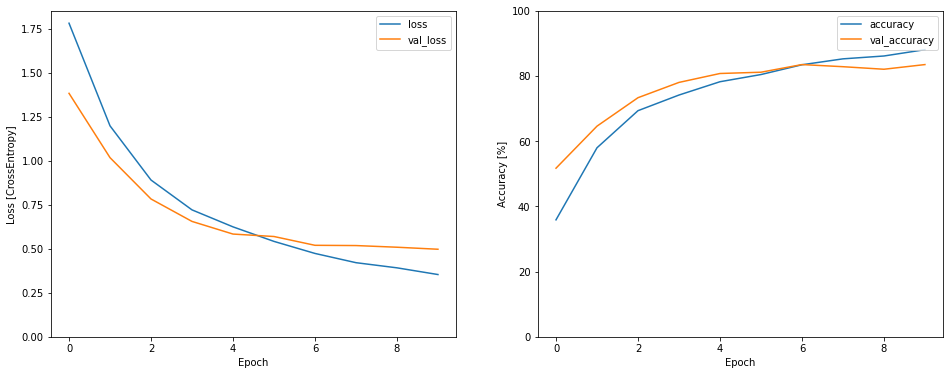

In [32]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

### Evaluating the model

In the following code cell we are going to evaluate our model based on the `test` dataset.

In [33]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 98ms/step - loss: 0.5202 - accuracy: 0.8450


{'loss': 0.5201628804206848, 'accuracy': 0.8449519276618958}

### Confusion Matrix

We are going to use the confusion matrix to check how well did the model classify our test dataset.

In [34]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 99ms/step


In [35]:
y_pred = tf.argmax(y_pred, axis=1)

In [36]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

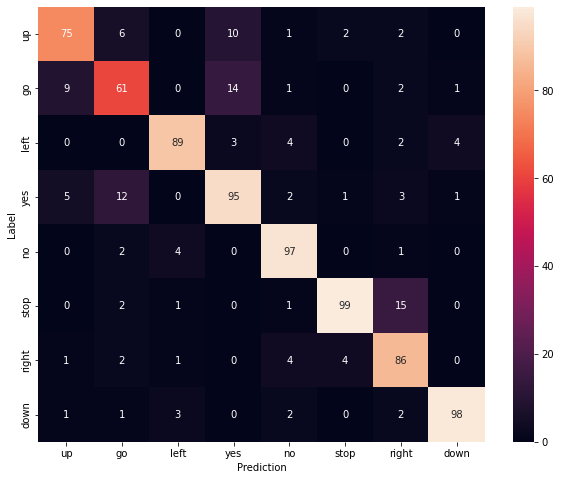

In [37]:
cm = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            xticklabels=commands,
            yticklabels=commands,
            annot=True,
            fmt='g'
          )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Model inference

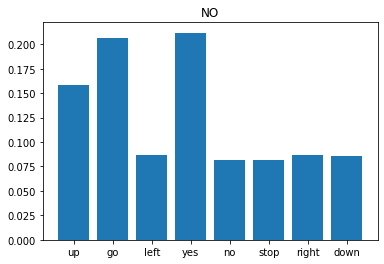

Predicted: 	YES
Real Label: 	NO


In [39]:
def predict_command(filename:str):
  label = filename.split('/')[2].upper()
  x = tf.io.read_file(filename)
  x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
  x = tf.squeeze(x, axis=-1) 
  waveform = x
  x = x[tf.newaxis, :]
  x = get_spectrogram(x)
  prediction = model(x, training=False)
  prediction = tf.squeeze(prediction)

  plt.bar(commands, tf.nn.softmax(prediction))
  plt.title(label)
  plt.show()
  print()
  display.display(display.Audio(waveform, rate=16000))
  print(f"Predicted: \t{commands[tf.argmax(prediction)].upper()}")
  print(f"Real Label: \t{label}")

predict_command(f"{data_dir}/no/01bb6a2a_nohash_0.wav")

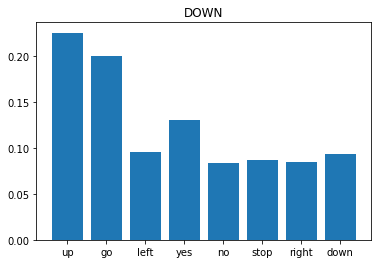

Predicted: 	UP
Real Label: 	DOWN


In [40]:
# Down
predict_command(f"{data_dir}/down/004ae714_nohash_0.wav")

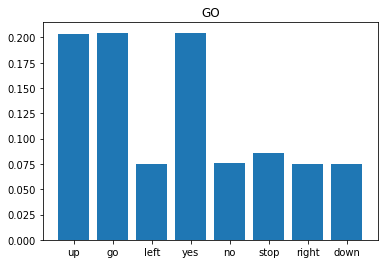

Predicted: 	GO
Real Label: 	GO


In [41]:
# Go
predict_command(f"{data_dir}/go/0132a06d_nohash_2.wav")

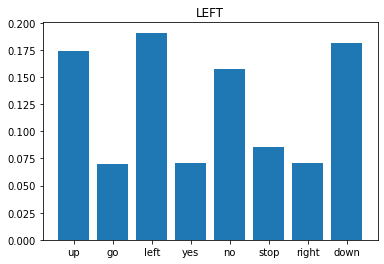

Predicted: 	LEFT
Real Label: 	LEFT


In [42]:
# Left
predict_command(f"{data_dir}/left/00b01445_nohash_0.wav")

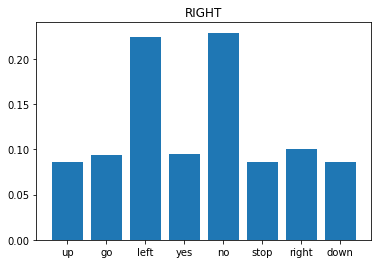

Predicted: 	NO
Real Label: 	RIGHT


In [43]:
# Right
predict_command(f"{data_dir}/right/012c8314_nohash_1.wav")

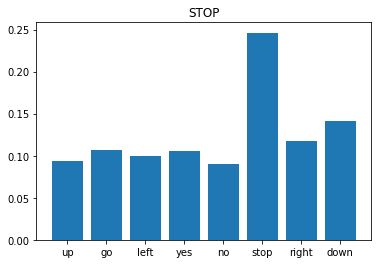

Predicted: 	STOP
Real Label: 	STOP


In [44]:
# Stop
predict_command(f"{data_dir}/stop/012c8314_nohash_0.wav")

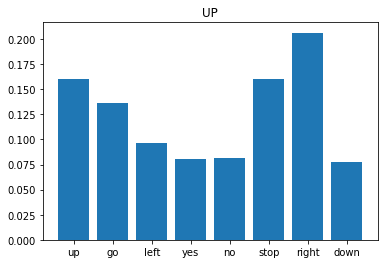

Predicted: 	RIGHT
Real Label: 	UP


In [45]:
# Up
predict_command(f"{data_dir}/up/0135f3f2_nohash_1.wav")

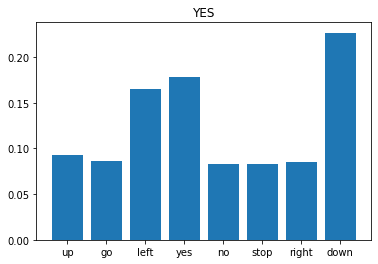

Predicted: 	DOWN
Real Label: 	YES


In [46]:
# Yes
predict_command(f"{data_dir}/yes/004ae714_nohash_0.wav")

### Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [47]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {
        'predictions':result,
        'class_ids': class_ids,
        'class_names': class_names
        }
      

Test the export model

In [48]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.7026832 , 0.96497667, 0.0985096 , 0.9914206 , 0.04259204,
         0.04312045, 0.09392077, 0.08874042]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [49]:
export(tf.constant(f"{data_dir}/yes/004ae714_nohash_0.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[1.0809633e-01, 3.1382956e-02, 6.8131727e-01, 7.5655597e-01,
         2.7057895e-04, 7.8368808e-05, 2.2104686e-02, 9.9997103e-01]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'yes'], dtype=object)>}

In [50]:
export(tf.constant(f"{data_dir}/right/012c8314_nohash_1.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.01525218, 0.1125915 , 0.98124355, 0.11319749, 0.99997103,
         0.02623629, 0.1758452 , 0.01705984]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

In [51]:
export(tf.constant(f"{data_dir}/up/0135f3f2_nohash_1.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.7381769 , 0.57422405, 0.2330861 , 0.0470156 , 0.05700529,
         0.7401864 , 0.99050003, 0.0166634 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'up'], dtype=object)>}

In [52]:
export(tf.constant(f"{data_dir}/go/0132a06d_nohash_2.wav"))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[9.9402398e-01, 9.9998474e-01, 3.6209480e-05, 9.9982435e-01,
         4.3766792e-03, 1.3103825e-01, 2.4734982e-04, 2.4273628e-05]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'go'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [53]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[9.9923480e-01, 2.3381169e-01, 4.8632022e-02, 8.8419479e-01,
         1.5132974e-02, 8.6104751e-02, 4.3788005e-04, 7.7855372e-01]],
       dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'down'], dtype=object)>}

### Ref

1. [tensorflow tutorials](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb#scrollTo=2-rayb7-3Y0I)